# G-17 

### Abstract

The Big Bang theory....ah no....this is another story... \
A long time ago.....oh ops again sorry....

In the next cells there is the final **best-score notebook** and at the end you can find our **trials and errors**(thah should not be considered into the running time) section with the development-strategies we took to arrive at the final result. 

From the beginning our main strategy was the one of reducing drastically the dimension of our dataset because *d*>>*n* and we have a lot of redundancies. For every change we immediately verified the validation error to understand if that change is effective or not. As described below the dataset is composed by different "parts" and we always worked on them separately and then at the end eventually merge them. Our first intuition was the one of binning the data, i.e. taking averages along the time axis of the spetrogram/cepstrum. We tried to bin both the spectrogram and the Mel cepstrum with different bin widths and at the end it turned out that the best chunk of featurues to bin is the Mel cepstrum (reasonable since they are a transformed and reduced spectrogram) with a bin width of 171, i.e, just the average on all the time axis for each Mel frequency. In this way we reduced/truncated the dimensions of our initial dataset to just 40 columns. 
Afterwards we included as a categorical variable the "genre" feature. 
At this point our **RMSE** was of about *12.3* and it seemes that no improvement could be made anymore.
To lower the error we approached many different strategies (described below) that at the end only reduced the score to *12.0*.  We were stuck at this score and we were afraid.

The *final-last-best* improvement involved using a **KernelPCA** that lowered our error to the current one of *8.74*.
We tried many models also, but without any competitor the best one was always the **SVM**.

## Best-score notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.svm import SVR

from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from scipy.signal import find_peaks
from scipy import stats

import time

In [2]:
np.random.seed(0)

### Input data

In [3]:
start_upload_data = time.time()
train = pd.read_csv('../input/statistical-learning-sapienza-spring-2020/train/train.csv')
test = pd.read_csv('../input/statistical-learning-sapienza-spring-2020/test/test.csv')
target = train['tempo']
del train['id']
del train['tempo']
test_id = test['id']
del test['id']
train.head()
end_upload_data = time.time()
upload_running_time = end_upload_data - start_upload_data

### Data Preprocessing

The dataset is divided in many sub-parts: the 2D spectrogram, the 2D spectrogram with Mel frequencies, the dominant frequency as a function of time and all the statistics/information about the signal. From the beginning our thought was the one of working on these pieces separately, since they are "non - coherent" data and at the end (after many trials) it turned out that the 2D cepstrum with the Mel frequencies are the best ones for our analysis.

In [4]:
start_algo_time = time.time()

In [5]:
# transform the genre as an object type variable
train['genre'] = train['genre'].astype('object')
test['genre'] = test['genre'].astype('object')

In [6]:
# take the Mel frequencies
test_mel = test.iloc[:,87552:94392]
train_mel = train.iloc[:,87552:94392]
test_mel.head()

,mel1_t1,mel1_t2,mel1_t3,mel1_t4,mel1_t5,mel1_t6,mel1_t7,mel1_t8,mel1_t9,mel1_t10,...,mel40_t162,mel40_t163,mel40_t164,mel40_t165,mel40_t166,mel40_t167,mel40_t168,mel40_t169,mel40_t170,mel40_t171
0,199.711940,198.039268,197.068860,197.903072,201.499091,205.218296,203.757790,204.088361,205.757582,209.921406,...,0.561312,-1.304268,-1.443784,0.916981,-0.075583,-0.905929,-0.766740,-1.076069,-0.459299,-0.532954
1,306.649177,304.207342,303.313035,302.056213,300.943103,299.383596,302.547714,301.284158,301.481392,307.355913,...,1.510341,0.304393,-2.052557,-2.159647,-0.956290,-0.861713,0.354209,0.724557,-0.665306,1.513816
2,289.971028,265.497521,226.968178,214.243889,206.501446,191.850913,178.746308,171.477220,164.479908,157.911160,...,-0.311857,-2.041523,-1.666284,-1.680397,-2.092428,-1.649799,0.038045,0.352503,0.036366,0.272055
3,285.999740,277.243260,295.882411,286.751714,280.861856,273.938436,302.133385,294.644743,290.228380,292.658565,...,-0.460111,-0.044401,-0.773339,-0.450417,-0.336943,1.019887,-0.275969,-0.239853,0.410744,0.236837
4,287.613112,282.218644,269.529909,269.168723,295.411622,289.526962,276.857901,271.841335,285.180037,276.292152,...,-0.168454,0.678879,-0.581830,-0.456151,-0.496251,0.024237,0.779222,0.009742,-0.067059,0.196230


We decided to bin the Mel frequencies along the time dimension of the cepstrum. More precisely from a 171 x 40 matrix (for a single song) we decided to transform it into an *m* x 40 matrix, where *m* dependes on the bin width, that in our case is 171. So at the end we reduced the matrix to a vector of shape 1 x 40.

In [7]:
# The binning function, that performs the above described operation, takes in input a dataframe d and a binwidth x 
# and gets in output the reduced matrix. 
# It is possible to see that different "group-by" functions has been tried, but we saw that keeping only the mean gave us the best
# results.

def binning(d,x):
    start = 0
    end = x
    diz = {}
    dim = d.shape[1]
    while start < dim:
        if end >= dim:
            temp = d[d.columns[start:dim]]
            mean = temp.mean(axis = 1)
            #median = temp.median(axis=1)
            #minimo = temp.min(axis = 1)
            #massimo = temp.max(axis = 1)
            #std = temp.std(axis=1)
            #diff = massimo-minimo
            diz[str(start)+'_'+str(dim)+'_mean'] = list(mean)
            #diz[str(start)+'_'+str(dim)+'_std'] = list(std)
            #diz[str(start)+'_'+str(dim)+'_median'] = list(median)
            #diz[str(start)+'_'+str(dim)+'_diff'] = list(diff)
            #diz[str(start)+'_'+str(dim)+'_minimo'] = list(minimo)
            #diz[str(start)+'_'+str(dim)+'_massimo'] = list(massimo)
            break
        else:     
            temp = d[d.columns[start:end]]
            mean = temp.mean(axis = 1)
            #median = temp.median(axis=1)
            #minimo = temp.min(axis = 1)
            #massimo = temp.max(axis = 1)
            #std = temp.std(axis=1)
            #diff = massimo-minimo
            diz[str(start)+'_'+str(dim)+'_mean'] = list(mean)
            #diz[str(start)+'_'+str(dim)+'_std'] = list(std)
            #diz[str(start)+'_'+str(dim)+'_median'] = list(median)
            #diz[str(start)+'_'+str(dim)+'_diff'] = list(diff)
            #diz[str(start)+'_'+str(dim)+'_minimo'] = list(minimo)
            #diz[str(start)+'_'+str(dim)+'_massimo'] = list(massimo)
            start += x
            end += x
    final = pd.DataFrame(diz)
    return final

In [8]:
# applying the binning function on train and test and standardizing them

train_mel = preprocessing.scale(binning(train_mel,171))
test_mel = preprocessing.scale(binning(test_mel,171))
train_mel.shape

(1561, 40)

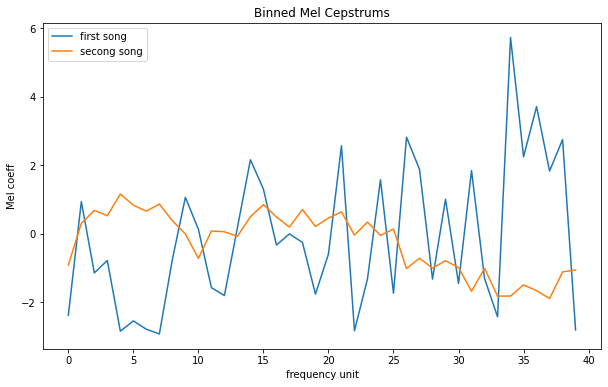

In [9]:
plt.figure(figsize=(10,6))
plt.plot(train_mel[0], label = 'first song')
plt.plot(train_mel[1], label = 'secong song')
plt.ylabel('Mel coeff')
plt.xlabel('frequency unit')
plt.legend()
plt.title('Binned Mel Cepstrums')
plt.show()

Here is our final improvement. We ran this code without the kernel pca until the last night obtaining a RMSE of $\approx$ 12.3. We tried a whole day different (and interesting) techniques that improved our score to $\approx$ 12.0. At the end, we went for a "dimensionality reduction" (or better just a trasformation our data) using a kernel pca that lowered our error from 12 to the current one of 8.74.

In [10]:
# Applying the kernel pca to the train and test. The cosine kernel with 40 components turned out to work pretty well for us

transformer = KernelPCA(n_components=40, kernel='cosine')
train_mel = transformer.fit_transform(train_mel)
test_mel = transformer.transform(test_mel)
train_mel.shape

(1561, 40)

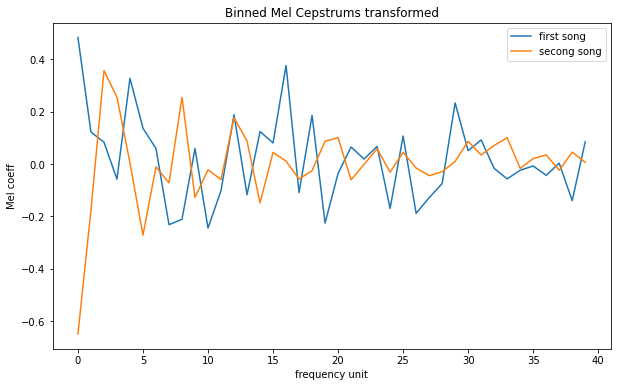

In [11]:
plt.figure(figsize=(10,6))
plt.plot(train_mel[0], label = 'first song')
plt.plot(train_mel[1], label = 'secong song')
plt.ylabel('Mel coeff')
plt.xlabel('frequency unit')
plt.title('Binned Mel Cepstrums transformed')
plt.legend()
plt.show()

In [12]:
train_mel = pd.DataFrame(train_mel)
test_mel = pd.DataFrame(test_mel)

In [13]:
# concatenate the transformed dataset and adding the dummied genre feature

train_mel = pd.concat([train_mel,pd.get_dummies(train['genre'], prefix='genre')], axis=1)
test_mel = pd.concat([test_mel,pd.get_dummies(test['genre'], prefix='genre')], axis=1)

### SVM Implementation

In [14]:
# Model tuning of the parameter(s) in the SVR model. The rbf turned out to work best for us. For each parameter the cross-validated 
# it with 5 folds.

'''
score = []
cs = np.arange(415,425,1)
#cs = [0.1,0.0001,0.00001]
for i in cs:
    reg = SVR(kernel='rbf', C=i,epsilon=0.0001)
    scores = cross_val_score(reg, train_mel, target, scoring='neg_root_mean_squared_error')
    #score.append(scores.mean())
    print(i, -scores.mean())
'''

"\nscore = []\ncs = np.arange(415,425,1)\n#cs = [0.1,0.0001,0.00001]\nfor i in cs:\n    reg = SVR(kernel='rbf', C=i,epsilon=0.0001)\n    scores = cross_val_score(reg, train_mel, target, scoring='neg_root_mean_squared_error')\n    #score.append(scores.mean())\n    print(i, -scores.mean())\n"

In [15]:
# our best parameters

reg = SVR(kernel='rbf', C=421, epsilon=0.0001)
reg.fit(train_mel,target)

SVR(C=421, epsilon=0.0001)

In [16]:
submission = pd.DataFrame({"id":test_id, "target":reg.predict(test_mel)})
submission.to_csv('submission_mel.csv', index=False)
#submission.round(decimals=0).to_csv('submission_mel_round.csv', index=False)

In [17]:
end_algo_time = time.time()
algo_running_time = end_algo_time - start_algo_time

In [26]:
# running times 

print('data import running time: ', upload_running_time, ' running time without upload time: ', algo_running_time, 
      ' TOTAL RUNNING TIME: ',upload_running_time + algo_running_time )

data import running time:  754.042014837265  running time without upload time:  3.0386829376220703  TOTAL RUNNING TIME:  757.0806977748871


## Trials and Errors (TO NOT BE RUNNED FOR THE COMPLETE MODEL)

As described in the abstract before the *final-last-best* improvement to lower the error we approached different techniques. \
First of all we tried to include in the binned Mel cepstrum the binned spectrogram and other statistics/signal analysis features, but none of these really worked for us. We went then to a peak analysis and some frequency analysis of the spectrogram.

#### Peak Analysis

Intuitively our binned cepstrum is a some kind of frequency spectrum and the peaks represent in this case the "most relevant" frequency in our audio signal. We expect the tempo to be a some kind of periodic wave in the audio signal, so one of the peak frequency should represent the frequency of that "tempo wave". From this intuition we focuse on the analysing the peaks of the binned Mel cepstrum.

In [19]:
train_mel = train.iloc[:,87552:94392]
train_mel = pd.DataFrame(preprocessing.scale(binning(train_mel,171)))
train_mel = pd.concat([train_mel, pd.get_dummies(train['genre'], prefix='genre')], axis=1)

In [20]:
from scipy.signal import find_peaks

mels = train_mel.iloc[:, range(40)]

df_peaks = []
for _, row in mels.iterrows():
    idx = find_peaks(row)[0]
    peak = sorted(row[idx], reverse = True)
    df_peaks.append(peak)
df_peaks = pd.DataFrame(df_peaks)

pd.concat([df_peaks.loc[:,0:2].apply(lambda x: 1/(1+x)), train_mel], axis = 1)

,0,1,2,0,1,2,3,4,5,6,...,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19,genre_20
0,0.148480,0.212203,0.261871,-2.392533,0.935647,-1.149428,-0.786058,-2.854037,-2.554580,-2.798286,...,0,0,0,0,0,0,0,0,0,0
1,0.463709,0.536549,0.541429,-0.916747,0.297977,0.678262,0.522465,1.156524,0.830572,0.657008,...,0,1,0,0,0,0,0,0,0,0
2,0.455507,0.542283,0.588670,0.851597,-0.719242,0.339248,0.124347,-0.217067,-0.668410,-0.062426,...,0,0,0,0,0,0,0,1,0,0
3,0.574651,0.653507,0.668672,1.039053,-0.526926,0.144905,-0.387387,-0.323296,-0.583999,0.023191,...,0,0,0,0,0,0,0,0,0,0
4,0.305920,0.421502,0.423983,-0.494471,0.698288,0.049712,-0.935523,-0.401631,1.372471,0.433023,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,0.318654,0.344839,0.357618,-2.067566,0.987155,1.122047,0.821886,-0.612711,1.899903,-0.001831,...,0,0,0,0,0,0,0,0,0,0
1557,0.387522,0.420487,0.444010,0.225240,1.172954,0.779227,0.404141,-0.064650,-0.722038,-0.696115,...,0,1,0,0,0,0,0,0,0,0
1558,0.357251,0.421553,0.536465,-0.102222,0.379051,-0.788352,0.088636,0.041143,0.719136,0.993233,...,0,1,0,0,0,0,0,0,0,0
1559,0.293051,0.379991,0.806937,0.494924,-0.568061,-0.320823,-0.578411,-0.213184,-0.734598,-0.791222,...,0,0,0,0,0,0,0,0,0,1


From our point of view it is not obvious that the highest frequency represents the tempo so we tried to include in the dataset the position of different peaks (so the frequency) and we took the inverse of it (period is in someway proportional to the inverse of frequency). 

With this method the cross validation error decreased by houndreds. We never tried to submit it in this way, even if it could lower by some tens the test error (something that happened with the next approach).

#### Dominant frequencies

In this strategy we tried to pull out the top-K dominant frenquencies from the spectrogram: the heuristic we used to define a dominant frequency is evaluating the mean of each frequency amplitude along the 171 time values, ordering this list in a decreasing order and then excracting the top-K frequencies with highest mean amplitude (where K is a positive integer number, we tried low values of K to reduce the dataset dimensions). \
The function that performs this operation, using also the frequency vector dataset, is the topK() function defined below. \
Once obtained the top-K, we worked on them using the binning() function defined and used above.
However, you can find all the history of this strategy line in the notebook versions named as "Michele (topK version)" or something similar.

In [21]:
freq_list = pd.read_csv('../input/statistical-learning-sapienza-spring-2020/freq_vector.csv')

In [22]:
freq_dict = {}

for i in range(len(freq_list)):
    freq_dict['fr'+str(i+1)] = float(freq_list.iloc[i,1])

In [23]:
def topK(data, freq_dict, K):
    
    freq_means_in_time = pd.DataFrame()

    for i in range(512):
        freq_means_in_time['fr'+str(i+1)] = data.iloc[:,i*171:(i+1)*171].mean(axis=1)
        
    dominant_freq = []

    for i in range(len(freq_means_in_time)):
        dominant_freq.append(list(freq_means_in_time.iloc[i, :].nlargest(K).index))
        
    top_10_freq = []
    row = 0
    f = 1

    
    for audio in dominant_freq:
        f = 1
        tmp_dict = {}
        for freq in audio:
            tmp_dict['domfreq'+str(f)] = freq_dict[freq]
            for t in range(1, 172):
                tmp_dict['domfreq'+str(f)+'_t'+str(t)] = data[freq+'_t'+str(t)][row]

            f += 1

        top_10_freq.append(tmp_dict)
        row += 1
        
    data_top10 = pd.DataFrame(top_10_freq)
    
    return data_top10

Starting from K=50, we have seen that decreasing the value of K we were improving our predictions and our score. \
In the end, we found that the best regression was obtained for K=1, so just considering the most important frequency as defined from us. \
Using K=1 and the mel frequencies we got the kaggle-score of $\approx$12.

In [24]:
K = 1
train_topK = topK(train, freq_dict, K)
#test_topK = topK(test, freq_dict, K)

train_topK.head()

,domfreq1,domfreq1_t1,domfreq1_t2,domfreq1_t3,domfreq1_t4,domfreq1_t5,domfreq1_t6,domfreq1_t7,domfreq1_t8,domfreq1_t9,...,domfreq1_t162,domfreq1_t163,domfreq1_t164,domfreq1_t165,domfreq1_t166,domfreq1_t167,domfreq1_t168,domfreq1_t169,domfreq1_t170,domfreq1_t171
0,0.312231,-6.561865,-8.293710,-10.549766,-12.353441,-11.693705,-9.712489,-7.596223,-6.574879,-6.310942,...,-6.952626,-4.472155,-2.224018,-2.381912,-5.861732,-8.663556,-12.076320,-10.746795,-5.741698,-3.958391
1,0.053833,-45.570389,-19.673696,-5.488497,-3.227922,-2.931500,-3.073336,-7.590599,-4.738467,-5.316016,...,-4.311319,-7.058540,-7.423267,-1.113808,-2.037963,-2.406068,-4.591956,-9.979909,-16.215838,-22.181799
2,0.064600,-3.393307,-14.550465,-7.032051,-2.831975,-5.482682,-5.838860,-8.538780,-8.628756,-6.503220,...,-26.946624,-28.834786,-6.817268,-4.489184,-18.171331,-25.146645,-21.647507,-8.943723,-7.946185,-14.191241
3,0.064600,-12.339368,-10.968532,-10.386425,-9.340246,-3.261477,-4.606440,-5.013850,-5.003385,-5.858400,...,-1.512138,-5.420198,-11.834602,-14.236168,-10.158517,-11.354174,-12.263392,-11.912473,-11.315031,-10.151236
4,0.075366,-20.234959,-35.445986,-27.585553,-37.466924,-57.156176,-33.720735,-27.978227,-33.222191,-16.700294,...,-23.243892,-3.450059,-15.231769,-23.559038,-15.070896,-9.978536,-13.734165,-18.191137,-12.080498,-4.618007
